In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
df = pd.read_csv('main_task_new.csv')
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta']

In [2]:
df.head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Для начала вынем данные из 'Cuisine Style' и 'Reviews'
### cuisine_style

In [4]:
def cuisine_stripper(row): #функиця для превращения элементов Cuisine Style в list
    row = row[1:-1:].split(",") #создаем список убирая скобки из строки слева и справа
    row = [i.strip(" '")for i in row]#удаляем у каждого элемента оставшиеся апострофы
    return row

df.cuisine_style = df.cuisine_style.fillna('')
df.cuisine_style = df.cuisine_style.apply(lambda row: cuisine_stripper(row))
df.cuisine_style = df.cuisine_style.apply(
    lambda row: np.nan if row == [''] else row) # на данном этапе удобнее будет оставить значения как nan

### reviews

In [5]:
# из строки убираем все лишнее и достаем даты
# на выходе получаем список
def reviews_stripper(row):
    row = row[row.find('],')+2::]
    row = row[row.find(' [')+2:row.find(']]'):]
    row = row.split(",")
    row = [i.strip(" '")for i in row]
    return row

# переводим даты из str в datetime


def str_to_datetime(row):
    if row != ['']:
        for num in range(len(row)):
            row[num] = pd.to_datetime(row[num])
    return row


df.reviews = df.reviews.apply(lambda row: reviews_stripper(row))
df.reviews = df.reviews.apply(lambda row: str_to_datetime(row))
df['last_review_time'] = df.reviews.apply(
    lambda row: row[0] if row != [''] else np.nan)
df['STL_review_time'] = df.reviews.apply(
    lambda row: row[1] if len(row) == 2 else row[0])

In [6]:
#Удаляем не нужные прецеденты и переводим временные прецеденты в года
df = df.drop(['reviews', 'url_ta', 'id_ta'], axis=1)
df.last_review_time = df.last_review_time.apply(lambda row: row.year)
df.STL_review_time = df.STL_review_time.apply(lambda row: row.year)

# Добавим несколько новых прецедентов

### city_restaurants_amount

колличество ресторанов в городе

url бесполезные для модели помогли нам собрать немного информации извне

In [7]:
def restaurants_amount(row):
    if row == 'Paris':
        return 15704
    if row == 'Stockholm':
        return 2801
    if row == 'London':
        return 17351
    if row == 'Berlin':
        return 5659
    if row == 'Munich':
        return 2883
    if row == 'Oporto':
        return 1865
    if row == 'Milan':
        return 6778
    if row == 'Bratislava':
        return 1047
    if row == 'Vienna':
        return 3831
    if row == 'Rome':
        return 10407
    if row == 'Barcelona':
        return 8748
    if row == 'Madrid':
        return 10408
    if row == 'Dublin':
        return 2124
    if row == 'Brussels':
        return 2368
    if row == 'Zurich':
        return 1678
    if row == 'Warsaw':
        return 2794
    if row == 'Budapest':
        return 2794
    if row == 'Copenhagen':
        return 1979
    if row == 'Amsterdam':
        return 3678
    if row == 'Lyon':
        return 2589
    if row == 'Hamburg':
        return 2889
    if row == 'Lisbon':
        return 4597
    if row == 'Prague':
        return 4656
    if row == 'Oslo':
        return 1197
    if row == 'Helsinki':
        return 1388
    if row == 'Edinburgh':
        return 1771
    if row == 'Geneva':
        return 1351
    if row == 'Ljubljana':
        return 547
    if row == 'Athens':
        return 2377
    if row == 'Luxembourg':
        return 659
    if row == 'Krakow':
        return 1546
    return


df['city_restaurants_amount'] = df.city.apply(
    lambda row: restaurants_amount(row))

### part_of_eu
часть европы в которой находится ресторан

In [8]:
def eu_part_add(row):
    if row in ['London', 'Dublin', 'Edinburgh']:
        return 'British Isles'
    elif row in ['Bratislava', 'Budapest', 'Krakow',
                 'Ljubljana', 'Prague', 'Warsaw']:
        return 'Eastern Europe'
    elif row in ['Copenhagen', 'Helsinki', 'Oslo', 'Stockholm']:
        return 'Northern Europe'
    elif row in ['Athens', 'Barcelona', 'Lisbon', 'Madrid',
                 'Milan', 'Oporto', 'Rome']:
        return 'Southern Europe'
    elif row in ['Amsterdam', 'Berlin', 'Brussels', 'Geneva', 'Hamburg',
                 'Luxembourg', 'Lyon', 'Munich', 'Paris', 'Vienna', 'Zurich']:
        return 'Western Europe'


df['part_of_eu'] = df.city.apply(lambda row: eu_part_add(row))

#### 4 новых прецедента исходящие из данных в таблице
****review_date_diff**** -- разница между последним и предпоследним обзором в годах
****ranking_percent**** -- соотношение места ресторана в топе города на колличество ресторанов в городе

****cuisine_amount**** -- колличество кухонь, которые ресторан готовит

****is_top_10%**** -- находится ли ресторан в топ 10% своего города

In [9]:
df['review_date_diff'] = df.last_review_time-df.STL_review_time
df['ranking_percent'] = df['ranking']/df['city_restaurants_amount']
df['cuisine_amount'] = df.cuisine_style.fillna('').apply(
    lambda row: len(row) if row != '' else np.nan)
df['is_top_10%'] = df.ranking_percent.apply(
    lambda row: 1 if row <= 0.10 else 0)

### Займемся пропусками
1. ***number_of_reviews*** -- из-за выбросов берем медиану, сами выбросы при удалении(даже самые экстремальные), негативно влияют на модель, поэтому было принято решение их оставить.
2. ***cuisine_amount*** -- опять же медиана, все что мы тут можем сказать что кухонь может быть минимум одна
3. ***last_review_time*** -- поставлено среднее значение
4. ***STL_review_time*** -- в некоторых reviews был лишь один обзор, так же NaN стоит если обзоров не было вообще, правильны решением я посчитал поставить среднее значение от последнего обзора
5. ***review_date_diff*** -- NaN тут только тогда, когда в last_review_time и STL_review_time или STL_review_time был NaN, так что сюда подставляю 0
6. ***price_range*** -- подставим самый часто встречающийся(70%) вариант
7. ***cuisine_style*** -- поменяем значение, но позже, пока то нам нужны NaN

In [10]:
df.number_of_reviews = df.number_of_reviews.apply(
    lambda row: df.number_of_reviews.median() if np.isnan(row) else row)
df.cuisine_amount = df.cuisine_amount.apply(
    lambda row: df.cuisine_amount.median() if np.isnan(row) else row)
temp = df.last_review_time.mean()
df.last_review_time = df.last_review_time.apply(
    lambda row: temp if pd.isnull(row) else row)
df.STL_review_time = df.STL_review_time.apply(
    lambda row: temp if pd.isnull(row) else row)
df['review_date_diff'] = df['review_date_diff'].apply(
    lambda row: 0 if pd.isnull(row) else row)
df['price_range'] = df['price_range'].apply(
    lambda row: '$$ - $$$' if pd.isnull(row) else row)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            40000 non-null  object 
 1   city                     40000 non-null  object 
 2   cuisine_style            30717 non-null  object 
 3   ranking                  40000 non-null  float64
 4   rating                   40000 non-null  float64
 5   price_range              40000 non-null  object 
 6   number_of_reviews        40000 non-null  float64
 7   last_review_time         40000 non-null  float64
 8   STL_review_time          40000 non-null  float64
 9   city_restaurants_amount  40000 non-null  int64  
 10  part_of_eu               40000 non-null  object 
 11  review_date_diff         40000 non-null  float64
 12  ranking_percent          40000 non-null  float64
 13  cuisine_amount           40000 non-null  float64
 14  is_top_10%            

# Выбросы
### На выбросы у нас есть два претендента, это number_of_reviews и rating
#### number_of_reviews

<AxesSubplot:>

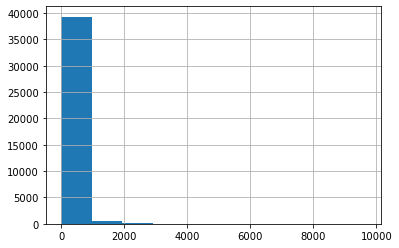

In [12]:
df.number_of_reviews.hist()

In [13]:
df.number_of_reviews.describe()

count    40000.000000
mean       118.987675
std        286.989212
min          2.000000
25%         10.000000
50%         33.000000
75%        105.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

Чтож выбросы действительно очевидны, но забегая вперед скажу что, перепробывал с ними все варианты и при замене/удалении результаты работы модели ухудшаются, брал разные квартили, заменял значения на разные варианты, и все ведет к ощутимому ухудшению работы модели, так что вероятно эти выбросы лучше чем их альтернативы. Да и выбросы вероятно не ошибочные, посто некоторые рестораны сильно популярнее других

<AxesSubplot:>

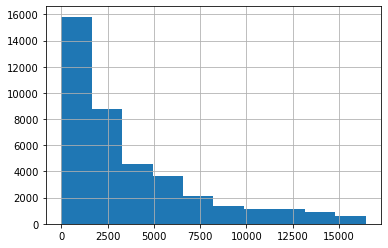

In [14]:
df.ranking.hist()

In [15]:
df.ranking.describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

Сам по себе прецидент достатчно спорный, он показывает место в рейтинге между ресторанами в городе, но при этом в одном городе может быть 50 ресторанов, а в другом 20000. С другой стороны так же не является ошибкой и возможно это число так же влияет на оценку. Удаление выбросов так или иначе, это лучшее для нас решение.

# EDA

In [16]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '70px', 'font-size': '10pt'})\
    .set_precision(2)

,ranking,rating,number_of_reviews,last_review_time,STL_review_time,city_restaurants_amount,review_date_diff,ranking_percent,cuisine_amount,is_top_10%
ranking,1.00,-0.37,-0.22,-0.19,-0.17,0.70,0.02,0.56,-0.29,-0.31
rating,-0.37,1.00,0.03,0.09,0.09,-0.05,-0.02,-0.55,0.12,0.19
number_of_reviews,-0.22,0.03,1.00,0.23,0.20,0.05,-0.02,-0.40,0.36,0.51
last_review_time,-0.19,0.09,0.23,1.00,0.83,0.01,0.04,-0.34,0.29,0.24
STL_review_time,-0.17,0.09,0.20,0.83,1.00,0.01,-0.53,-0.31,0.29,0.21
city_restaurants_amount,0.70,-0.05,0.05,0.01,0.01,1.00,-0.02,-0.03,-0.05,0.01
review_date_diff,0.02,-0.02,-0.02,0.04,-0.53,-0.02,1.00,0.05,-0.08,-0.01
ranking_percent,0.56,-0.55,-0.40,-0.34,-0.31,-0.03,0.05,1.00,-0.44,-0.53
cuisine_amount,-0.29,0.12,0.36,0.29,0.29,-0.05,-0.08,-0.44,1.00,0.39
is_top_10%,-0.31,0.19,0.51,0.24,0.21,0.01,-0.01,-0.53,0.39,1.00


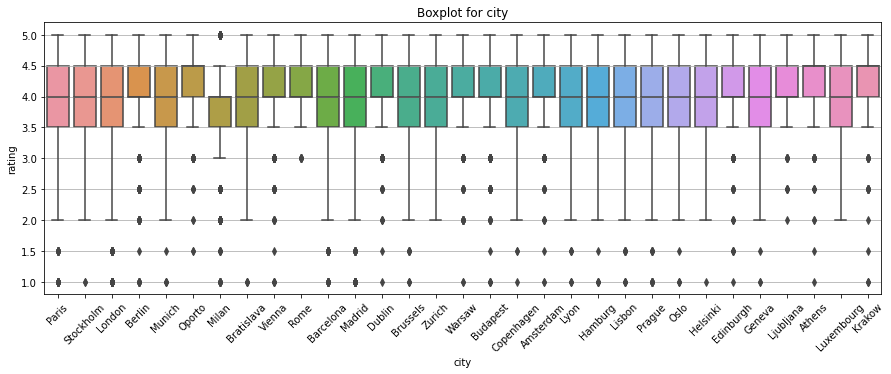

In [17]:
def score_boxplot(column):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(x=column, y='rating',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    ax.grid(axis="y")
    plt.show()


score_boxplot('city')

Выводами из eda можно сделать, то, что: у нас довольно много коррелирующй друг с другом прецедентов, выделятся две тройки времени(slt, last и diff) и оценки (ranking/city_restaurants_amount/ranking percent), ranking и ranking percent иммеют самую большу корреляцию с rating, средняя оценка у городов общая

# Фиктивные переменные
Пора бы нам привести часть предецентов в форму подходящую для модели
## City

In [18]:
#Для начала, чтобы модель лучше работа с фиктивными переменными
#уменьшим колличество городов, поменяв редко встречающиеся на other
city_freq = list(df.city.value_counts()) #создаем список из значений городов
city_count = int(np.percentile(city_freq, 25)) #вычисляем персентиль
temp = sum(i > city_count for i in city_freq) #сумма "хороших" городов
all_city = df.city.value_counts().index #список всех городов
top_city = list(all_city)[:temp] # оставляем лучше города(они идут по возрастанию)
city_throw_away = list(set(all_city)-set(top_city))#вычитаем из всех лучшие
df.loc[df['city'].isin(city_throw_away), 'city'] = 'other' #меняем значение неугодных городов
df = pd.concat([df, pd.get_dummies(df.city)], axis=1)  #Создаем переменные
df = df.drop(['city'], axis=1) #удаляем city

# cuisine_style
Переменные не в самом приятном для нас формате, но мы все же можем кое-что сделать

In [19]:
def rowIndex(row): #выдает индекс строки
    return row.name

#Получает индекс строки
#Смотрит есть ли в 1 в столбцах"неугодных" прецедентов
#если есть, то возвращает 1, если нет то 0
def cuisine_other_check(row):
    row = int(row)
    for i in range(len(cuisine_throw_away)):
        if df[cuisine_throw_away[i]][row] != 0:
            return 1
    return 0
#создаем дф побоный команде value_counts()
#повторяем все то же что делали в city,но пока не меняем значения
cuisine_freq = df.cuisine_style.apply( 
    lambda x: pd.Series(x).value_counts()).sum()
cuisine_freq = cuisine_freq.sort_values(ascending=False)
cuisine_counter = int(np.percentile(cuisine_freq, 75))
temp = sum(i > cuisine_counter for i in cuisine_freq)
all_cuisine = cuisine_freq.index
top_cuisine = list(all_cuisine)[:temp]
cuisine_throw_away = list(set(all_cuisine)-set(top_cuisine))
mlb = MultiLabelBinarizer() #cоздаем дамми переменные
df.cuisine_style = df.cuisine_style.fillna('0')
temp = df.cuisine_style
df = pd.concat([df, pd.DataFrame(mlb.fit_transform(temp), 
               columns=mlb.classes_, index=df.index)], axis=1)
#временно создаем столбец с индексом
df['rowIndex'] = df.apply(rowIndex, axis=1)
#создаем прецедент Other_cuisines, в него будем ставить неугодные нам кухни
df['Other_cuisines'] = df.rowIndex.apply(
    lambda row: cuisine_other_check(row))
#удаляем столбцы с неугодными кухнями перемещая их значение в ther_cuisines
df = df.drop(cuisine_throw_away, axis=1)
df = df.drop(['rowIndex', 'cuisine_style'], axis=1)#удаляем строку с индексами

In [20]:
# price_range дамми
df = pd.concat([df, pd.get_dummies(df.price_range)], axis=1)
df = df.drop(['price_range'], axis=1)

In [21]:
# part_of_eu дамми
df = pd.concat([df, pd.get_dummies(df.part_of_eu)], axis=1)
df = df.drop(['part_of_eu'], axis=1)

# Тест модели

In [22]:
X = df.drop(['restaurant_id', 'rating'], axis=1)
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20869049999999997
